# Tutorial 3: Problems and Solvers

**Overview:** This tutorials covers the basics of setting up and solving problems using Dedalus.
Dedalus solves symbolically specified initial value, boundary value, and eigenvalue problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from dedalus.extras.plot_tools import plot_bot_2d
figkw = {'figsize':(6,4), 'dpi':100}

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 3.1: Problems

### Problem formulations

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations boundary conditions and manipulating them into the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.
This form encapsulates prognostic/evolution equations (equations containing time derivatives) and diagnostic/algebraic constraints (equations without time derivatives), both in the interior of the domain and on the boundary.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

In addition to initial value problems, there are similar standard forms for generalized eigenvalue problems ($\sigma \mathcal{M} \cdot \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = 0$), linear boundary value problems ($\mathcal{L} \cdot \mathcal{X} = \mathcal{G}$), and nonlinear boundary value problems ($\mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X})$).
These four problem types are represented by the `IVP`, `EVP`, `LBVP`, and `NLBVP` problem classes, respectively.

### Problem initialization

To create a problem object, you must provide a list of the field variables to be solved for.
You can pass a dictionary via the `namespace` argument during problem instantiation to make substitutions (operators or functions) available when parsing the equations later on.
Typically we suggest passing `locals()` here, to make all script-level definitions available inside the problem.

Let's start setting up the complex Ginzburg-Landau equation (CGLE) for a variable $u(x,t)$ on a finite interval $x \in [0, 300]$ with homogeneous Dirichlet boundary conditions:

$$\partial_t u = u + (1 + i b) \partial_{xx} u - (1 + i c) |u|^2 u$$

$$u(x=0) = u(x=300) = 0$$

We'll discretize $x$ with a Chebyshev basis and pick a dealiasing factor of 2 to correctly dealias the cubic nonlinearity.

This version of Dedalus currently requires explicilty adding [tau terms](../pages/tau_method.rst) as unknowns to the problem in order to enforce boundary conditions.
This problem requires two constant tau terms to enforce the two endpoint boundary conditions.

In [3]:
# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

# Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

# Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())

### Substitutions

A little more about substitutions, or using non-variable objects inside the problem.
These can include other fields that define e.g. the forcing or non-constant coefficients (NCCs) of the PDE.
NCCs appearing on the LHS will couple the dimensions that they have bases for, so it's important to only use bases for the non-constant dimensions when creating an NCC field.

We don't have NCCs or periodic dimensions here, but we'll sketch the process here anyways.
Consider a 3D problem on a Fourier (x), SinCos (y), and Chebyshev (z) domain.
Here's how we would add a simple non-constant coefficient in z to a problem:

In [4]:
#ncc = dist.Field(bases=zbasis)
#ncc['g'] = z**2

Substitutions can also include aliases to operators computed from the problem variables or helper functions that streamline the equation entry.
For instance, here we'll create simple substitutions for calling the `Differentiate` operator, for computing the squared magnitude `u`, defining the $a$ and $b$ parameters in the PDE, and defining the tau polynomials (see the [Tau Method](../pages/tau_method.rst) page for more info):

In [5]:
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

# Tau polynomials
tau_basis = xbasis.derivative_basis(2)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

### Equation entry


Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.
In addition to the substitutions available through the provided `namespace`, the string parsing recognizes all the built-in operators as well as abbreviations for some of them.

Let's enter the CGLE and the boundary conditions:

In [6]:
# Add main equation, with linear terms on the LHS and nonlinear terms on the RHS
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(dx(u)) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")

# Add boundary conditions
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

{'eqn': interp(<Field 4673496016>, x=right),
 'LHS': interp(<Field 4673496016>, x=right),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([ True]),
 'M': 0,
 'L': interp(<Field 4673496016>, x=right),
 'F': <Field 4675680464>,
 'domain': <dedalus.core.domain.Domain at 0x16a8932d0>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

## 3.2: Solvers

### Building a solver

Each problem type (IVP, EVP, LBVP, and NLBVP) has a corresponding solver class that actually performs the solution steps for a corresponding problem.
Solvers are simply built using the `problem.build_solver` method.

For IVPs, we select a timestepping method when building the solver.
Several multistep and Runge-Kutta IMEX schemes are available (see the list in the [timesteppers module](../autoapi/dedalus/core/timesteppers/index.html)), and can be selected by name.

In [7]:
# Build solver
solver = problem.build_solver(d3.RK222)

2025-07-15 09:54:39,976 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


### Setting stop criteria

For IVPs, stopping criteria for halting time evolution are specified by setting the `solver.stop_iteration`, `solver.stop_wall_time` (seconds since solver instantiation), and/or `solver.stop_sim_time` attributes.  

Let's stop at $t = 500$ in simulation units:

In [8]:
# Stopping criteria
solver.stop_sim_time = 500

### Setting initial conditions

For IVPs and nonlinear BVPs, the initial conditions are set by directly modifying the state variable data before running a simulation.

In [9]:
# Setup a sine wave
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)

### Solving/iterating a problem

IVPs are iterated using the `solver.step` method with a provided timestep.
EVPs are solved using the `solver.solve_dense` or `solver.solve_sparse` methods.
LBVPs are solved using the `solver.solve` method.
NLBVPs are iterated using the `solver.newton_iteration` method.

The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, storing the grid values of `u` every few iterations.
We explicitly retrieve the grid values of `u` with scales of `1` since field data is internally converted to the dealias scales when the RHS operators are evaluated each step.
We also explicitly copy the grid values because the integrator updates the field's data in place.
This should take just a few seconds to run.

In [10]:
# Setup storage
u_list = [u['g',1].copy()]
t_list = [solver.sim_time]

# Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 10 == 0:
        u_list.append(u['g',1].copy())
        t_list.append(solver.sim_time)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

# Convert storage lists to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2025-07-15 09:54:46,205 solvers 0/1 INFO :: Simulation stop time reached.


Now let's make a space-time plot of the magnitude of the solution:

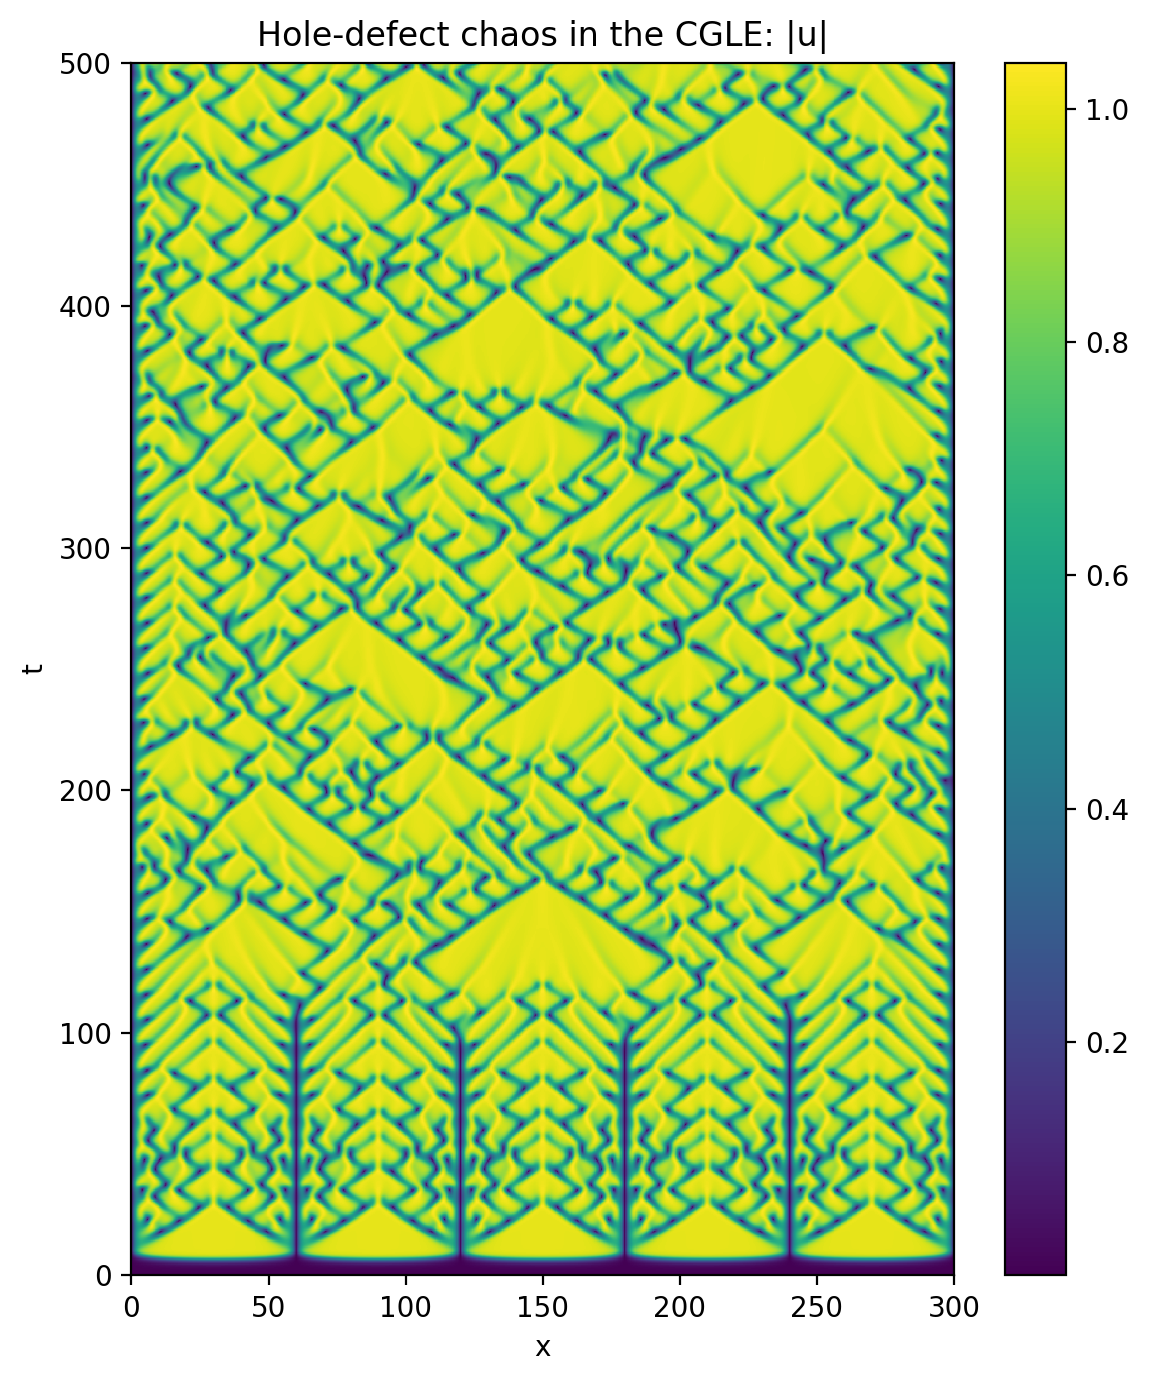

In [11]:
# Plot solution
plt.figure(figsize=(6, 7), dpi=100)
plt.pcolormesh(x, t_array, np.abs(u_array), shading='nearest')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Hole-defect chaos in the CGLE: |u|')
plt.tight_layout()